# Response Surface Methodology (RSM)

- designed to optimize continuous parameters


## Optimize a single continuous parameter

In [146]:
import numpy as np

In [182]:
def markout_profit(threshold):
    cost = 1
    pps = 1
    signal = np.random.normal()
    eps = 2 * np.random.normal()
    if signal > threshold or signal < -threshold:
        profit = pps * np.abs(signal) - cost + eps
    else:
        profit = 0
    return profit

In [183]:
def run_experiment(num_ind, thresholds):
    individual_measurements = {threshold: [] for threshold in thresholds}
    done = set()
    while True:
        threshold = np.random.choice(thresholds)
        profit = markout_profit(threshold)
        individual_measurements[threshold].append(profit)
        if len(individual_measurements[threshold]) >= num_ind:
            done.add(threshold)
        if len(done) == len(thresholds):
            break

    aggregate_measurements = []
    standard_errors = []
    for threshold in thresholds:
        ims = np.array(individual_measurements[threshold])
        aggregate_measurements.append(ims.mean())
        standard_errors.append(ims.std() / np.sqrt(len(ims)))

    return (
        aggregate_measurements,
        standard_errors,
    )

In [184]:
np.random.seed(17)
thresholds = np.array([0.5, 1.0, 1.5])
aggregate_measurements, standard_errors = run_experiment(15_000, thresholds)

In [185]:
aggregate_measurements, standard_errors

([0.09848496576216006, 0.1711214205711533, 0.13699263220703944],
 [0.013267765976681866, 0.00957041724519083, 0.006796544642991194])

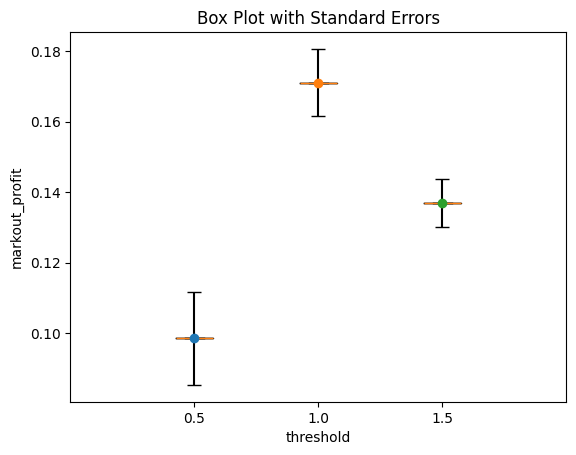

In [186]:
import matplotlib.pyplot as plt
import numpy as np


def boxplot(data, std_err, positions):
    # Create figure and axis
    fig, ax = plt.subplots()

    # Plot violin plot
    ax.boxplot(data, positions=positions)

    # Add standard error bars
    for i, (x, y, serr) in enumerate(zip(positions, data.flatten(), std_err)):
        ax.errorbar(x, y, yerr=serr, fmt="o", capsize=5, ecolor="black")

    # Set title and labels
    ax.set_title("Box Plot with Standard Errors")
    ax.set_xlabel("threshold")
    ax.set_ylabel("markout_profit")

    # Show plot
    plt.show()


# Sample data
data = np.array(aggregate_measurements).reshape(1, -1)
std_err = standard_errors
positions = thresholds
boxplot(data, std_err, positions)

In [187]:
def linear_regression(thresholds, aggregate_measurements):
    x = thresholds
    y = aggregate_measurements
    X = np.array([np.ones(len(y)), x, x**2]).T
    beta = np.linalg.inv(X.T @ X) @ (X.T @ y)
    return beta

In [188]:
beta = linear_regression(thresholds, aggregate_measurements)
beta

array([-0.08091673,  0.46556864, -0.21353049])

In [189]:
def interpolate(thresholds, beta):
    xhat = np.arange(thresholds.min(), thresholds.max() + 1e-6, 0.01)
    XHat = np.array([np.ones(len(xhat)), xhat, xhat**2]).T
    yhat = XHat @ beta
    return xhat, yhat

In [190]:
def optimize(thresholds, beta):
    xhat, yhat = interpolate(thresholds, beta)
    i = np.where(yhat == yhat.max())[0][0]
    return xhat[i], yhat[i]

In [191]:
beta = linear_regression(thresholds, aggregate_measurements)
threshold_opt, estimated_max_profit = optimize(thresholds, beta)
threshold_opt, estimated_max_profit

(1.0900000000000005, 0.17285751361179258)

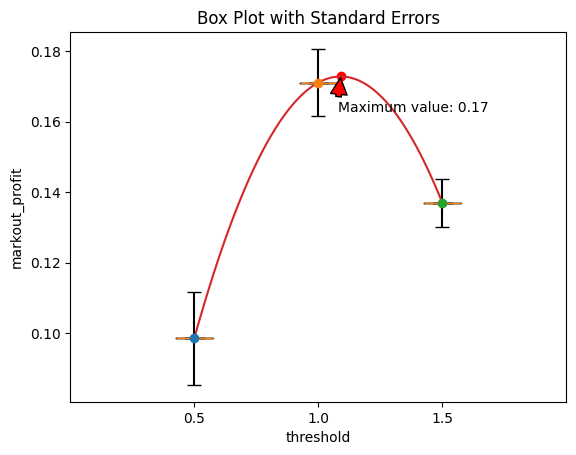

In [192]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = np.array(aggregate_measurements).reshape(1, -1)
std_err = standard_errors

# Create figure and axis
fig, ax = plt.subplots()

# Plot violin plot
ax.boxplot(data, positions=thresholds)

# Add standard error bars
for i, (x, y, serr) in enumerate(zip(thresholds, aggregate_measurements, std_err)):
    ax.errorbar(x, y, yerr=serr, fmt="o", capsize=5, ecolor="black")

# Set title and labels
ax.set_title("Box Plot with Standard Errors")
ax.set_xlabel("threshold")
ax.set_ylabel("markout_profit")

xhat = np.arange(thresholds.min(), thresholds.max() + 1e-6, 0.01)
XHat = np.array([np.ones(len(xhat)), xhat, xhat**2]).T
yhat = XHat @ beta

ax.plot(xhat, yhat)

max_x = threshold_opt
max_y = estimated_max_profit
# Annotate the maximum point
plt.annotate(
    f"Maximum value: {max_y:.2f}",
    xy=(max_x, max_y),
    xytext=(max_x - 0.01, max_y - 0.01),
    arrowprops=dict(facecolor="red", shrink=0.05),
)

# Alternatively, we can just use scatter to indicate the maximum point.
plt.scatter(max_x, max_y, color="red", marker="o")


# Show plot
plt.show()

In [193]:
np.random.seed(17)
aggregate_measurement, standard_error = run_experiment(15_000, [threshold_opt])
(
    aggregate_measurement[0] - 2 * standard_error[0],
    aggregate_measurement[0] + 2 * standard_error[0],
)

(0.14048962175141153, 0.17627270610659548)

## Optimizing two or more continuous parameters

In [194]:
def markout_profit_2D(threshold, order_size):
    cost = 1
    pps = 1  # Profit per signal

    # Adverse selection cost.
    asc = 0.001 * np.exp(2 * order_size)
    signal = np.random.normal()
    eps = 2 * np.random.normal()

    # Buy when signal is strong positive,
    # sell when the signal is strong negative.
    if signal > threshold or signal < -threshold:
        # Profit is offset by adverse selection.
        profit = order_size * (pps * np.abs(signal) - cost + eps) - asc
    else:
        # There is no profit if we don't trade.
        profit = 0
    return profit

In [195]:
# Face-centered central composite design
def design_ccd(thresholds, order_sizes):
    parameters = [
        (threshold, order_size)
        for threshold in thresholds
        for order_size in order_sizes
    ]
    return parameters

In [196]:
parameters = design_ccd(thresholds=[0.5, 1.0, 1.5], order_sizes=[1, 1.5, 2])
parameters

[(0.5, 1),
 (0.5, 1.5),
 (0.5, 2),
 (1.0, 1),
 (1.0, 1.5),
 (1.0, 2),
 (1.5, 1),
 (1.5, 1.5),
 (1.5, 2)]

In [197]:
import random


def run_experiment_2D(num_ind, parameters):
    individual_measurements = {parameter: [] for parameter in parameters}
    done = set()
    while True:
        parameter = random.choice(parameters)
        threshold, order_size = parameter
        profit = markout_profit_2D(threshold, order_size)
        individual_measurements[parameter].append(profit)
        if len(individual_measurements[parameter]) >= num_ind:
            done.add(parameter)
        if len(done) == len(individual_measurements):
            break

    aggregate_measurements = []
    standard_errors = []
    for parameter in parameters:
        ims = np.array(individual_measurements[parameter])
        aggregate_measurements.append(ims.mean())
        standard_errors.append(ims.std() / np.sqrt(len(ims)))

    return aggregate_measurements, standard_errors

In [235]:
np.random.seed(17)
# parameters = design_ccd(thresholds=[1, 1.5, 2], order_sizes=[1, 1.5, 2])
# parameters = design_ccd(thresholds=[0.5, 1, 1.5], order_sizes=[2.5, 3.0, 3.5])
parameters = design_ccd(thresholds=[0.75, 1, 1.25], order_sizes=[2.75, 3.0, 3.25])

aggregate_measurements, standard_errors = run_experiment_2D(15_000, parameters)
aggregate_measurements, standard_errors

([0.24897158926458934,
  0.2471849810777762,
  0.15409356871578675,
  0.364353742338055,
  0.37121735405452116,
  0.2792437553120961,
  0.36909242986238794,
  0.3829431544583351,
  0.4107278813489993],
 [0.030550297041633135,
  0.03373418353956968,
  0.036446385825462,
  0.026168866415857923,
  0.027991287030070783,
  0.03078311703802708,
  0.02160351382118412,
  0.023935059014066853,
  0.02536403334584761])

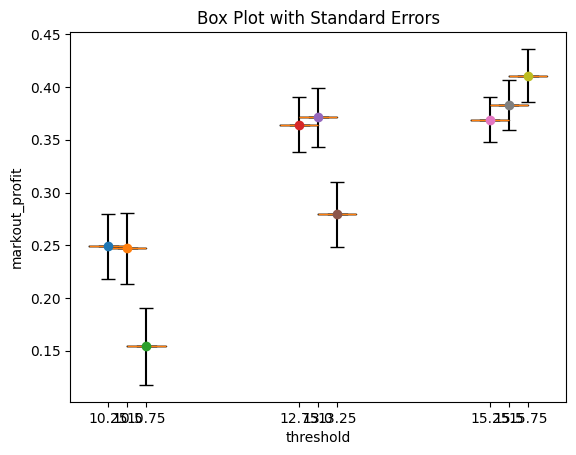

In [236]:
data = np.array(aggregate_measurements).reshape(1, -1)
std_err = standard_errors
positions = [i[0] * 10 + i[1] for i in parameters]
boxplot(data, std_err, positions)

### Linear regression for two parameters

In [237]:
def linear_regression_2D(parameters, aggregate_measurements):
    parameters = np.array(parameters)
    x0 = parameters[:, 0]
    x1 = parameters[:, 1]
    y = aggregate_measurements
    X = np.array([np.ones(len(y)), x0, x1, x0**2, x1**2, x0 * x1]).T
    beta = np.linalg.inv(X.T @ X) @ (X.T @ y)
    return beta

In [238]:
beta = linear_regression_2D(parameters, aggregate_measurements)
beta

array([-2.87559372, -0.14120025,  2.18103927, -0.57764293, -0.46988803,
        0.54605389])

In [239]:
def interpolate_2D(parameters, beta):
    parameters = np.array(parameters)
    x0_values = np.arange(parameters[:, 0].min(), parameters[:, 0].max() + 1e-6, 0.01)
    x1_values = np.arange(parameters[:, 1].min(), parameters[:, 1].max() + 1e-6, 0.01)
    x0hat_2d, x1hat_2d = np.meshgrid(x0_values, x1_values)
    x0hat = x0hat_2d.flatten()
    x1hat = x1hat_2d.flatten()
    XHat = np.array(
        [np.ones(len(x0hat)), x0hat, x1hat, x0hat**2, x1hat**2, x0hat * x1hat]
    ).T
    yhat = XHat @ beta
    yhat_2d = np.reshape(yhat, (len(x1_values), len(x0_values)))
    return x0hat_2d, x1hat_2d, yhat_2d

In [240]:
def optimize_2D(parameters, beta):
    x0hat, x1hat, yhat = interpolate_2D(parameters, beta)
    i = np.where(yhat == yhat.max())
    return x0hat[i][0], x1hat[i][0], yhat[i][0]

In [241]:
beta = linear_regression_2D(parameters, aggregate_measurements)
threshold_opt, order_size_opt, estimated_max_profit = optimize_2D(parameters, beta)
threshold_opt, order_size_opt, estimated_max_profit

(1.2500000000000004, 3.0499999999999936, 0.4082056915720207)

In [242]:
x0hat, x1hat, yhat = interpolate_2D(parameters, beta)

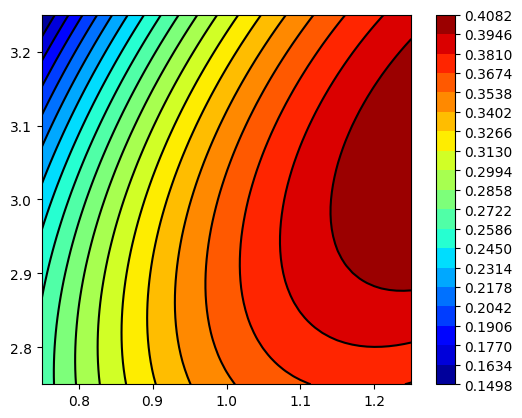

In [243]:
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import RegularGridInterpolator

# http://en.wikipedia.org/wiki/File:Bilininterp.png
xi = x0hat
yi = x1hat
zi = yhat


# I want 20 "levels" to be shown
contour_breaks = 20
ticks = np.linspace(zi.min(), zi.max(), contour_breaks, endpoint=True)

fig = plt.figure()
axes = fig.add_subplot(111, aspect="equal")
axes.contour(xi, yi, zi, ticks[1:-1], colors="k")
fill = axes.contourf(xi, yi, zi, ticks, cmap=cm.jet)
fig.colorbar(fill, ticks=ticks)

# Show the plots
plt.show()

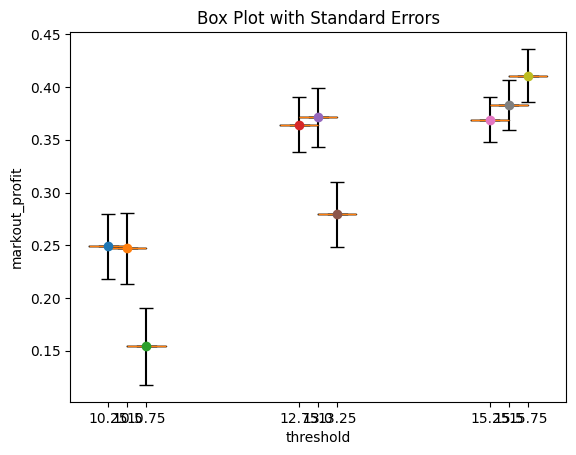

In [244]:
data = np.array(aggregate_measurements).reshape(1, -1)
std_err = standard_errors
positions = [i[0] * 10 + i[1] for i in parameters]
boxplot(data, std_err, positions)

In [247]:
aggregate_measurements, standard_error = run_experiment_2D(
    15_000, parameters=[(threshold_opt, order_size_opt)]
)
aggregate_measurements, standard_error

([0.35282741607659324], [0.023736160734659388])

In [248]:
(
    aggregate_measurement[0] - 2 * standard_error[0],
    aggregate_measurement[0] + 2 * standard_error[0],
)

(0.11090884245968473, 0.20585348539832227)